# Algorithmic Trading - Assignment 3

In [59]:
# load in appropriate packages
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
print('setup complete')

setup complete


In [60]:
class Assignment3():

    def __init__(self, train_data_file, test_data_file):

        self.train_data = pd.read_csv(train_data_file)
        self.test_data = pd.read_csv(test_data_file)

    @classmethod
    def evaluate(cls, model, test_features, test_labels):

            predictions = model.predict(test_features)

            absolute_errors = abs(predictions - test_labels)
            mae = np.mean(absolute_errors)
            print('Mean Absolute Error: {:0.4f}'.format(mae))

    def fill_na(self):

        self.train_data = self.train_data.ffill()
        self.train_data = self.train_data.bfill()
        self.test_data = self.test_data.ffill()

    def check_order(self, data):

        if not np.all(data.sort_values('epochhours').index == data.index):

            data = data.sort_values('epochhours')

    def calculate_mids(self):

        self.train_data['midDealerQuotes'] = (self.train_data['firm_executable_bid']
                                              + self.train_data['firm_executable_ask']) / 2

        self.train_data['midMarketEstimate'] = (self.train_data['market_estimate_bid']
                                              + self.train_data['market_estimate_ask']) / 2

        self.test_data['midDealerQuotes'] = (self.test_data['firm_executable_bid']
                                              + self.test_data['firm_executable_ask']) / 2

        self.test_data['midMarketEstimate'] = (self.test_data['market_estimate_bid']
                                              + self.test_data['market_estimate_ask']) / 2
    
    def calculate_returns(self, data):
        # LastPrice, midDealerQuotes, midMarketEstimate 
        data['LastPrice_rets'] = (data['last_price'] / data['last_price'].shift(1) -1) * 10000
        data['midDealerQuotes_rets'] = (data['midDealerQuotes'] / data['midDealerQuotes'].shift(1) -1) * 10000
        data['midMarketEstimate_rets'] = (data['midMarketEstimate'] / data['midMarketEstimate'].shift(1) -1) * 10000
    
    def make_matrices(self):
        self.Y = np.array(self.train_data['LastPrice_rets'][1:])
        self.X = np.ones((len(self.train_data)-1 , 3))
        self.X[:,1] = self.train_data['midDealerQuotes_rets'][1:]
        self.X[:,2] = self.train_data['midMarketEstimate_rets'][1:] 
        return
    
    def est_OLS(self):
        self.betas = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y
        print('estimated betas are equal to')
        print(f'constant                              = {round(self.betas[0], 4)}')
        print(f'midDealerQuotes returns coefficient   = {round(self.betas[1], 4)}')
        print(f'midMarketEstimate returns coefficient = {round(self.betas[2], 4)}')
        
        return 
    
    def get_yhat(self):
        self.yhat = self.X @ self.betas
        return
    
    def get_r2(self):
        self.r2 = 1 - np.sum( (self.Y - self.yhat)**2) / np.sum( (self.Y - np.mean(self.Y))**2)
        print(f'R squared = {self.r2}')
        return 
    
    def get_MAE(self):
        self.MAE = np.mean(abs(self.Y - self.yhat))
        
        print(f'MAE       = {self.MAE}')
        return 
        
        
    def OLS_Q8(self):
        X = np.array(self.train_data[[
                'last_price'
            ]].iloc[:-1,:])
        
        Y = np.array(self.train_data['last_price'].iloc[1:])
        
        betas = np.linalg.inv(X.T @ X) @ X.T @ Y
        
        print(f'betas are {betas}')
        print()
        
        X_test = np.array(self.test_data[[
                'last_price'
            ]].iloc[0:-1, :])
        
        errors = self.test_data.iloc[1:, 1] - X_test @ betas
        print(errors)
        print()
        
        print(f'MAE of OLS question 8 = {np.mean(abs(errors))}')
        
    def flow_bid_and_ask(self):
        
        self.test_data.iloc[:, 7] = self.test_data.iloc[:, 6] * 1.001
        self.test_data.iloc[:, 8] = self.test_data.iloc[:, 6] * 0.999
        plt.xlabel('Epoch Hours')
        plt.ylabel('Value')
        plt.title('Predicted Spread')
        plt.plot(range(len(self.test_data.iloc[1:, 8])), self.test_data.iloc[1:,8], label = 'Bid')
        plt.plot(range(len(self.test_data.iloc[1:, 6])), self.test_data.iloc[1:,6], label = 'FlowTradersMidpoint')
        plt.plot(range(len(self.test_data.iloc[1:, 7])), self.test_data.iloc[1:,7], label = 'Ask')
        plt.legend()
        

    def generate_plots(self):

        # Create figure.
        fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize=(6,6))

        #fig.suptitle('Epoch Hours vs LastPrice, midDealerQuotes and midMarketEstimate')

        axs[0, 0].set_ylabel('Value')
        
        axs[0, 0].plot(
            self.train_data['epochhours'],
            self.train_data['last_price'],
            color = 'orange'
        )
        axs[0, 0].set_title("Last Price vs Epoch Hours")

        axs[0, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midDealerQuotes'],
            color = 'green'
        )
        axs[0, 1].set_title("midDealerQuotes vs Epoch Hours")

        axs[1, 0].plot(
            self.train_data['epochhours'],
            self.train_data['midMarketEstimate'],
            color = 'blue'
        )

        axs[1, 0].set_title("midMarketEstimate vs Epoch Hours")

        axs[1, 0].set_xlabel('Epoch Hours')
        axs[1, 0].set_ylabel('Value')

        axs[1, 1].set_title("All vs Epoch Hours")

        axs[1, 1].set_xlabel('Epoch Hours')

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['last_price'],
            label = 'Last Price',
            color = 'orange',
            alpha = 0.5
        )

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midDealerQuotes'],
            label = 'midDealerQuotes',
            color = 'green',
            alpha = 0.3
        )

        axs[1, 1].plot(
            self.train_data['epochhours'],
            self.train_data['midMarketEstimate'],
            label = 'midMarketEstimate',
            color = 'blue',
            alpha = 0.3
        )
        
        
        plt.tight_layout()
        plt.legend()
        plt.show()

    def random_forest(self):

        # Training features
        x_train = self.train_data[[
                'epochhours',
                'firm_executable_bid',
                'firm_executable_ask',
                'market_estimate_bid',
                'market_estimate_ask',
                'midDealerQuotes',
                'midMarketEstimate']].iloc[:-1,:]

        # Training target variable.
        y_train = self.train_data['last_price'].iloc[1:]

        # Testing features
        x_test = self.test_data[[
                'epochhours',
                'firm_executable_bid',
                'firm_executable_ask',
                'market_estimate_bid',
                'market_estimate_ask',
                'midDealerQuotes',
                'midMarketEstimate'
            ]].iloc[:-1,:]

        # Testing true y.
        y_test = self.test_data['last_price'].iloc[1:]

        # Number of trees.
        n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 1)]

        # Number of features at each split.
        max_features = ['auto', 'sqrt']

        # Maximum number of levels in tree.
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)

        # Minimum number of samples to split.
        min_samples_split = [2, 5, 10, 15]

        # Minimum number of samples required at each leaf.
        min_samples_leaf = [1, 2, 4, 6, 8]

        # Method of selecting samples for training each tree.
        bootstrap = [True, False]

        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
        }

        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        random_forest = RandomForestRegressor()

        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        random_forest_random_search = RandomizedSearchCV(
            estimator = random_forest,
            param_distributions = random_grid,
            n_iter = 100,
            cv = 3,
            verbose = 2,
            random_state = 42,
            n_jobs = -1
        )

        # Fit the random search model
        random_forest_random_search.fit(x_train, y_train)

        # Compare base model and optimised random forest.
        print('\nBase model:')
        base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
        base_model.fit(x_train, y_train)
        Assignment3.evaluate(base_model, x_test, y_test)

        print('\nBest Optimised model:')
        best_random = random_forest_random_search.best_estimator_
        Assignment3.evaluate(best_random, x_test, y_test)

        # Put predicted last price in test dataframe
        self.test_data.iloc[1:, 6] = best_random.predict(x_test)

    def plot_predicted_vs_actual(self):

        plt.plot(
            self.test_data['epochhours'],
            self.test_data['last_price'],
            label = 'Last Price'
        )

        plt.plot(
            self.test_data['epochhours'],
            self.test_data['FlowTradersMidpoint '],
            label = 'FlowTradersMidpoint'
        )

        plt.title('Predicted last price (FlowTradersMidpoint) vs actual last price')
        plt.xlabel('Epoch Hours')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

In [61]:
# Setup filepaths.
# Get current working directory.
cwd = os.curdir

# Get data file paths.
train_data_file = os.path.join(cwd, 'Bond_MidModelTraining.csv')
test_data_file = os.path.join(cwd, 'Bond_QuoteLive.csv')

# Instantiate Assignment3
assignment = Assignment3(train_data_file, test_data_file)


In [62]:
# Fill nans.
assignment.fill_na()

# check if both sets are ordered properly by epochhours
assignment.check_order(assignment.train_data)
assignment.check_order(assignment.test_data)

# calculate mid prices
assignment.calculate_mids()

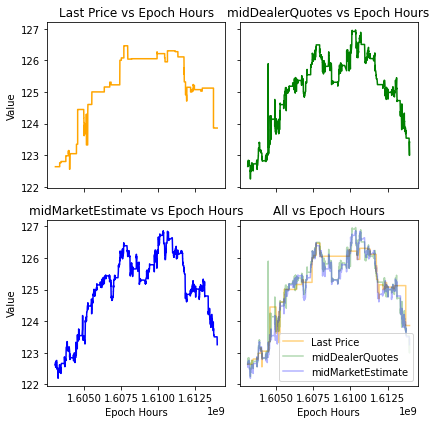

In [63]:
# fill in flow bid and ask
assignment.generate_plots()

In [64]:
# calculate returns
assignment.calculate_returns(assignment.train_data)

In [65]:
# OLS here
assignment.make_matrices()
assignment.est_OLS() # estimate OLS using analytical solution
assignment.get_yhat() # calculate the estimated Y
assignment.get_r2() # calculate r2
assignment.get_MAE() # calculate mean absolute error

estimated betas are equal to
constant                              = 0.0498
midDealerQuotes returns coefficient   = -0.0
midMarketEstimate returns coefficient = -0.0001
R squared = 4.479969395454475e-09
MAE       = 0.6517414190500567


In [66]:
# OLS Q8
assignment.OLS_Q8()

betas are [1.00000457]

1     -0.000572
2     -0.000572
3     -0.000572
4     -0.000572
5     -0.000572
         ...   
176   -0.000567
177   -0.000567
178   -0.000567
179   -0.000567
180   -0.000567
Name: last_price, Length: 180, dtype: float64

MAE of OLS question 8 = 0.00758085962394001


In [67]:
assignment.random_forest()

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Base model:
Mean Absolute Error: 0.9848

Best Optimised model:
Mean Absolute Error: 0.0941


We make use of a random forest for its versatility, ability to handle non-linear data and quick training and prediction speed. Given that we were unable to intuitively pick features, we included all of them in our random forest and left the algorithm to determine which features are most important. Those features are:

1. Epoch hours
2. Firm executable bid
3. Firm executable ask
4. Market estimate bid
5. Market estimate ask
6. Mid dealer quotes
7. Mid market estimate 

We setup a random search routine to optimise the hyperparameters which was largely taken from [this Medium article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) due to our lack of experience with hyperparameter tuning. The search space setup was largely arbitrary since all of the hyperparameters which were being tuned relate to the construction and size of the trees and not to do with the data itself. Here we largely followed the lead of our source while increasing the size of the search space. Our hyperparameter tuning routine proved to be very effective with mean absolute error (MAE) decreasing greatly from our base Random Forest model with no hyperparameter tuning. Finally, we input our best model's predictions into our dataframe in the 'FlowTradersMidpoint' column.

Below, we plot our model predictions along with the respective bid and ask prices.

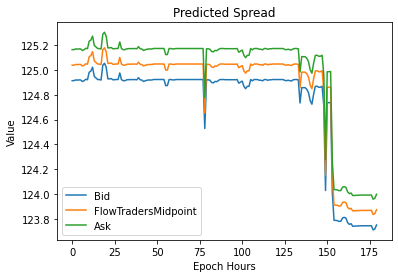

In [68]:
assignment.flow_bid_and_ask()

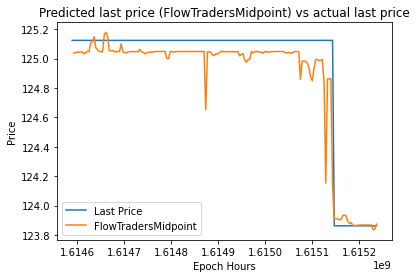

In [69]:
# Plot predicted last price and actual last price.
assignment.plot_predicted_vs_actual()

Here we plot our predicted last prices, as predicted by our best Random Forest model, against the realised last prices. We see that our model performs relatively well given that the last prices are forward- and back-filled meaning there was very little variance in our algorithm's target variable. Our model generally underprices the subsequent last price, but it does show promise in reducing last price predictions in advance of a large drop in the large price. This suggests there is indeed some information in the features we included which, when combined, have some predictive power. Our cross-validation of our model when tuning our hyperparameters means that we were also unlikely to overfit and we see that in our results.

###### Question 8c

If we assume that:
1. The 1% increase will come true
2.  We expect the 1% increase to be persistent

Then we would either slightly increase our bid or leave it as is and increase our ask in line with the expected 1% increase. This way we are likely to build up an net positive inventory of the bond such that once the 1% increase realises we are in a position to either profitably offload the bonds at a later date (based on the persistance of the increase) or offload immediately to lock in profit.

###### Question 8d